[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ferraresso/mineria_textos/blob/master/Mineria_de_Textos.ipynb)

In [ ]:
!mkdir input
!wget -O input/train.csv.gz https://meli-data-challenge.s3.amazonaws.com/train.csv.gz

In [ ]:
import nltk
nltk.download('stopwords')

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from tqdm import tqdm as tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

### Introduccion
El trabajo realizado consiste en un modelo que pueda clasificar productos del sitio Mercado Libre, a partir del titulo que tiene el post de la venta. El dataset usado sale de una competencia (https://ml-challenge.mercadolibre.com) creada por la compañia, que probee 10 millones de ejemplos de productos, en idioma español y portugues.<br/>
En este caso vamos a trabajar unicamente con el idioma español, aunque la misma metodologia funciona con similares resultados para el portuges.

### Lectura y filtrado del dataset
Primero, levantamos el dataset completo y filtramos para trabajar unicamente con el idioma español. Luego mostramos los primeros ejemplos del dataset filtrado.

In [2]:
LANGUAGE = 'spanish'#'portuguese'
train = pd.read_csv('input/train.csv.gz')
train = train[train.language == LANGUAGE]
print('Cantidad de ejemplos', train.shape[0])


Cantidad de ejemplos 10000000


In [3]:
train.head(5)

,title,label_quality,language,category
0,Hidrolavadora Lavor One 120 Bar 1700w Bomba A...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,Placa De Sonido - Behringer Umc22,unreliable,spanish,SOUND_CARDS
4,Flashes Led Pestañas Luminoso Falso Pestañas P...,unreliable,spanish,FALSE_EYELASHES
9,Gatito Lunchera Neoprene,unreliable,spanish,LUNCHBOXES
11,Rosario Contador De Billetes Uv / Mg Detecta F...,unreliable,spanish,BILL_COUNTERS


Se puede notar facilmente que los titulos son escritos de forma bastante concreta. Tambien se ve que suelen contener numeros y algunos caracteres raros. Las categorías estan nombradas en ingles, ahora veamos la cantidad de categorias que hay para los casos en español.

In [4]:
print('Cantidad de categorias', train.category.unique().shape[0])

Cantidad de categorias 1574


### Filtrando ejemplos confiables
El dataset contiene un atributo que indica la calidad de la categoria asignada. Las que tienen valor 'reliable' significa que la categoria fue chequeada por una persona, las que tienen 'unreliable' son categorias asignadas por el vendedor, pero que no fueron validadas por gente de Mercado Libre. A continuacion filtraremos para quedarnos las confiables, a ver cuanto representan del dataset.

In [5]:
train = train[train.label_quality == 'reliable']
print('Cantidad de ejemplos confiables', train.shape[0])

Cantidad de ejemplos confiables 490927


Nos queda un 5% del dataset total, lo que significa una reduccion muy importante. Ahora veamos si esos ejemplos cubren todas las categorias, y si quedan con una cantidad aceptable de casos para cada una.

In [6]:
print('Cantidad de categorias', train.category.unique().shape[0])

Cantidad de categorias 1062


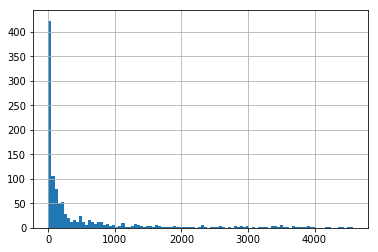

In [7]:
train.groupby('category')['title'].count().hist(bins=100)

In [8]:
train.groupby('category')['title'].count().describe()

count    1062.000000
mean      462.266478
std       865.860784
min         1.000000
25%        19.000000
50%        93.000000
75%       453.500000
max      4575.000000
Name: title, dtype: float64

La primer observacion es que hay 512 categorias que no tienen ejemplos confiables. Lo segundo, es que hay un 25% de categorias que no llegan a 20 ejemplos, y la mitad no llega a tener 100 ejemplos. <br/>
Estas dos observaciones nos marcan que es inevitable tener que incluir los datos que son menos confiables.

### Agregando datos no confiables
Dado que hay categorias que tienen una buena cantidad de ejemplos confiables, la idea no es incluir los ejemplos menos confiables por partes iguales a cada categoría. Por ende, la incorporación de datos no confiables se va a hacer en 2 partes.
- Primero, se van a incluir ejemplos de las categorias que no estan contempladas en los confiables. Se van a elegir mil ejemplos a azar de cada categoria.
- Segundo, para cada categoria que no consiga llegar a los mil ejemplos confiables, se van a incluir ejemplos no confiables al azar para alcanzar esa cantidad. En los casos que no se llege a esa cantidad quedara el maximo disponible de esa categoria.


La cantidad de mil se elige para tratar de tener un dataset medianamente balaceado, queda pendiente hacer la prueba con otras cantidades para ver si generan mejoras en los resultados

In [9]:
train_un = pd.read_csv('input/train.csv.gz')
train_un = train_un[train_un.language == LANGUAGE]
train_un = train_un[train_un.label_quality == 'unreliable']

In [10]:
print('Cantidad de ejemplos menos confiables', train_un.shape[0])

Cantidad de ejemplos menos confiables 9509073


Filtramos los ejemplos con categorias que no tenemos aun en train

In [11]:
unkn_category = train_un[~train_un.category.isin(train['category'].unique())].category
train_un.shape

(9509073, 4)

Validamos que sea la cantidad correcta de categorias

In [12]:
unkn_category.nunique()

512

In [13]:
MIN_SAMPLES_CATEGORY = 1000

Ahora debemos realizar el segundo punto. Para eso primero vemos cuantas categorias quedaron con menos de mil ejemplos

In [14]:
g = train.groupby('category').count()
g = g[g.title < MIN_SAMPLES_CATEGORY]
unbancaled_cats = np.asarray(list(g.index))
print(len(unbancaled_cats))

916


Unimos las dos lista de categorias que se deberian buscar entre las no confiables

In [15]:
cats_to_add = np.concatenate([unkn_category.unique(), unbancaled_cats], axis=0)
print(cats_to_add.shape)

(1428,)


Filtramos el dataset de los menos confiables para que solo tenga categorias de esa lista

In [16]:
to_add = train_un[train_un.category.isin(cats_to_add)]
to_add.shape

(7760739, 4)

Nos quedamos con a lo sumo 1000 ejemplos por cada categoria

In [17]:
g = to_add.groupby('category')
g = pd.DataFrame(g.apply(lambda x: x.sample(min(len(x), MIN_SAMPLES_CATEGORY))).reset_index(drop=True))
print(g.shape)

(1312936, 4)


Los agregamos al train

In [18]:
train = pd.concat([train, g], axis=0)
train.shape

(1803863, 4)

Finalmente comprobamos que train tenga todas las categorias necesarias

In [19]:
print('Cantidad de categorias', train.category.unique().shape[0])

Cantidad de categorias 1574


Claramente tenemos un aumento en la cantidad de ejemplos. Veamos como quedo la distribucion de ejemplos por categoria

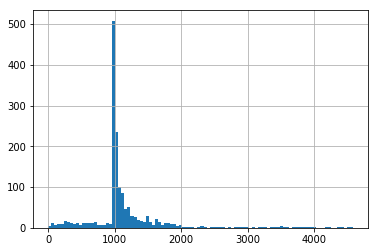

In [20]:
train.groupby('category')['title'].count().hist(bins=100)

In [21]:
train.groupby('category')['title'].count().describe()

count    1574.000000
mean     1146.037484
std       577.676993
min         2.000000
25%      1000.000000
50%      1016.000000
75%      1173.750000
max      4575.000000
Name: title, dtype: float64

Si bien quedaron algunas etiquetas con pocos ejemplos, mejoro mucho la cantidad en general.

In [22]:
del train_un, to_add, g

### Limpiando un poco los textos
Se va a limpiar el texto de varias formas simples
- Primero se convierte todo a minusculas y se eliminan los tildes, para evitar palabras duplicadas.
- Luego se eliminarán algunos simbolos que no aportan a la descripcion de un producto.
- Dado que los numeros se utilizan a veces como nombre de producto no se van a eliminar, pero si se van a reemplazar por un caracter comun (#) dado que generalmente la diferencia en el nro de un mismo texto indica diferentes versiones del mismo producto y no productos de tipos diferentes.
- Por ultimo, se eliminan las stopwords comunes del español, salvo la palabra "te" que es un producto. Tambien se quitan los caracteres que queden sueltos.



In [23]:
def nlp_clean_cnn(data):
    new_str = data.lower()
    new_str = new_str.replace(';', ' ')
    new_str = new_str.replace('"', ' ')
    new_str = new_str.replace('!', ' ')
    new_str = new_str.replace('?', ' ')
    new_str = new_str.replace('.', ' ')
    new_str = new_str.replace(',', ' ')
    new_str = new_str.replace('(', ' ')
    new_str = new_str.replace(')', ' ')
    new_str = new_str.replace('=', ' ')
    new_str = new_str.replace('#', ' ')
    new_str = new_str.replace('$', ' ')
    new_str = new_str.replace('/', ' ')
    new_str = new_str.replace(']', ' ')
    new_str = new_str.replace('[', ' ')
    new_str = new_str.replace('-', ' ')
    new_str = new_str.replace('-', ' ')
    new_str = new_str.replace('º', ' ')
    new_str = new_str.replace('á', 'a')
    new_str = new_str.replace('é', 'e')
    new_str = new_str.replace('í', 'i')
    new_str = new_str.replace('ó', 'o')
    new_str = new_str.replace('ú', 'u')

    new_str = new_str.replace('0', '#')
    new_str = new_str.replace('1', '#')
    new_str = new_str.replace('2', '#')
    new_str = new_str.replace('3', '#')
    new_str = new_str.replace('4', '#')
    new_str = new_str.replace('5', '#')
    new_str = new_str.replace('6', '#')
    new_str = new_str.replace('7', '#')
    new_str = new_str.replace('8', '#')
    new_str = new_str.replace('9', '#')

    return new_str

In [24]:
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

reg_tokenizer = RegexpTokenizer(r'[A-Za-z]\w+')
stopword_set = set(stopwords.words(LANGUAGE))
stopword_set.remove('te')
def nlp_clean(data):
    max_words = 0
    new_data = []
    for i,d in tqdm(enumerate(data)):
        try:
            new_str = d
            new_str = nlp_clean_cnn(new_str)
            dlist = reg_tokenizer.tokenize(new_str)
            dlist = [d for d in dlist if d not in stopword_set]
            dlist = [d for d in dlist if len(d) > 1]
            new_data.append(' '.join(dlist))
        except AttributeError:
            new_data.append('sintexto')
    return new_data

In [25]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [26]:
terminos = train.copy()

In [27]:
terminos['title'] = nlp_clean(terminos['title'])
terminos.head()

1803863it [00:21, 85393.11it/s]


,title,label_quality,language,category
267,play station volante hooligans,reliable,spanish,GAME_CONSOLES
272,pilas energizer max aa tira pilas,reliable,spanish,CELL_BATTERIES
287,afeitadora electrica philips hq envio gratis,reliable,spanish,SHAVING_MACHINES
386,estufa calefactor volcan kcal salida mandy,reliable,spanish,HOME_HEATERS
449,reloj pared vox tronic blanco numeros cm garan...,reliable,spanish,WALL_CLOCKS


### Buscamos stopwords propias del contexto del problema
Veamos el top 200 de palabras mas usadas luego de la limpieza, para ver de limpiar algunas mas que suelen ser muy usadas pero que en si no aportan a la descripcion del producto, serían stopwords propias del contexto de éste trabajo.

In [28]:
get_top_n_words(terminos.title, n=200)

[('mm', 58995),
 ('cm', 58629),
 ('original', 50548),
 ('kit', 43165),
 ('led', 33145),
 ('kg', 30796),
 ('caja', 25921),
 ('madera', 25381),
 ('envio', 24556),
 ('gb', 24427),
 ('juego', 23638),
 ('unidades', 23020),
 ('negro', 22987),
 ('acero', 22849),
 ('set', 22781),
 ('oferta', 22362),
 ('usb', 20816),
 ('nuevo', 20346),
 ('pack', 19724),
 ('ml', 19709),
 ('mini', 19558),
 ('luz', 19435),
 ('ford', 19367),
 ('mesa', 19318),
 ('bateria', 19149),
 ('digital', 18703),
 ('doble', 17373),
 ('fiat', 17156),
 ('pro', 16789),
 ('blanco', 16609),
 ('aire', 16465),
 ('gratis', 16186),
 ('combo', 16093),
 ('color', 15966),
 ('renault', 15492),
 ('hp', 15489),
 ('mts', 15483),
 ('peugeot', 15264),
 ('bomba', 15249),
 ('funda', 15246),
 ('tapa', 14982),
 ('aluminio', 14711),
 ('cable', 14350),
 ('electrico', 14317),
 ('profesional', 14231),
 ('agua', 14077),
 ('soporte', 14000),
 ('vw', 13933),
 ('cuero', 13924),
 ('motor', 13793),
 ('camara', 13603),
 ('cocina', 13582),
 ('chevrolet', 13497)

Se ven varias palabras relacionadas con unidades de medida, que indican diferentes tamaños mas que productos diferentes, por lo que optaré por quitarlas. Tambien hay otras relacionada a la venta (como "envio", "nueva", "oferta", "excelente", etc) que no aportan a clasificar el producto, por lo que tambien opto por quitarlas.

In [29]:
def remove_stopwords(sentence):
    stop = ['cm',
            'original',
            'mm',
            'kit',
            'kg',
            'envio',
            'gb',
            'ml',
            'unidades',
            'set',
            'negro',
            'oferta',
            'ford',
            'pack',
            'nuevo',
            'gratis',
            'combo',
            'mts',
            'lts',
            'talle',
            'nueva',
            'nuevo',
            'uso',
            'cuotas',
            'cc',
            'tipo',
            'excelente',
            'pulgadas',
            'litros',
            'colores',
            'color',
            'calidad',
            'gr',
            'envios',
            'impecable',
            'completo',
            'vendo',
            'mas',
]
    return ' '.join([i for i in sentence.split() if i not in stop and len(i) > 1])

In [30]:
terminos['title'] = terminos['title'].apply(lambda x: remove_stopwords(nlp_clean_cnn(x)))
terminos.head()

,title,label_quality,language,category
267,play station volante hooligans,reliable,spanish,GAME_CONSOLES
272,pilas energizer max aa tira pilas,reliable,spanish,CELL_BATTERIES
287,afeitadora electrica philips hq,reliable,spanish,SHAVING_MACHINES
386,estufa calefactor volcan kcal salida mandy,reliable,spanish,HOME_HEATERS
449,reloj pared vox tronic blanco numeros garantia...,reliable,spanish,WALL_CLOCKS


In [31]:
get_top_n_words(terminos.title, n=200)

[('led', 33145),
 ('caja', 25921),
 ('madera', 25381),
 ('juego', 23638),
 ('acero', 22849),
 ('usb', 20816),
 ('mini', 19558),
 ('luz', 19435),
 ('mesa', 19318),
 ('bateria', 19149),
 ('digital', 18703),
 ('doble', 17373),
 ('fiat', 17156),
 ('pro', 16789),
 ('blanco', 16609),
 ('aire', 16465),
 ('renault', 15492),
 ('hp', 15489),
 ('peugeot', 15264),
 ('bomba', 15249),
 ('funda', 15246),
 ('tapa', 14982),
 ('aluminio', 14711),
 ('cable', 14350),
 ('electrico', 14317),
 ('profesional', 14231),
 ('agua', 14077),
 ('soporte', 14000),
 ('vw', 13933),
 ('cuero', 13924),
 ('motor', 13793),
 ('camara', 13603),
 ('cocina', 13582),
 ('chevrolet', 13497),
 ('vidrio', 13472),
 ('reloj', 13021),
 ('control', 12849),
 ('electrica', 12751),
 ('mujer', 12615),
 ('tv', 12594),
 ('bebe', 12317),
 ('samsung', 12292),
 ('hombre', 12185),
 ('portatil', 12088),
 ('baño', 11913),
 ('modelo', 11897),
 ('porta', 11257),
 ('maquina', 11253),
 ('pc', 11213),
 ('bolsa', 11197),
 ('super', 11076),
 ('base', 109

### Armar conjuntos de datos para train y test
Primero vamos a mezclar los datos para que no alla nada del orden que pueda afectar y luego dividimos en dos partes para tener un conjunto de entrenamiento y otro de prueba. Dado que hay casi 2 millones de ejemplos, vamos a separar 90% para train y 10 para test, que nos deja con casi 200 mil ejemplos de prueba. Utilizamos la opcion "stratify" para que la distribucion de las etiquetas se mantenga entre test y train. 

In [32]:
terminos = terminos.sample(frac=1.0)
terminos.head(10)

,title,label_quality,language,category
23402,polea alternador zen reemplaza cargo,unreliable,spanish,ALTERNATOR_PULLEYS
772677,tempera escolar maped peps metalica pote,unreliable,spanish,MARKERS_AND_HIGHLIGHTERS
1096982,clips metal aluminio esteril vendas elasticos ...,unreliable,spanish,SPORT_AND_MEDICAL_BANDAGES
57245,puerta trasera vw fox suran,unreliable,spanish,AUTOMOTIVE_DOORS
603257,menzerna corta abrillanta encera detail center,unreliable,spanish,HAND_POLISHERS
646009,modulo encendido escort cabrio coupe,unreliable,spanish,IGNITION_CONTROL_MODULES
573242,pinza pico loro blister,unreliable,spanish,GROOVE_JOINT_PLIERS
1105403,espatula herramienta apertura yaxun yx spudger...,unreliable,spanish,STEEL_SCRAPERS
869168,switch rackeable tp link ports tl sg,unreliable,spanish,NETWORK_SWITCHES
846790,the little horror shop tiendita horrores taza ...,unreliable,spanish,MUGS


In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(terminos, test_size=0.1, stratify=terminos.category)
print(train.shape)
print(test.shape)

(1623476, 4)
(180387, 4)


### Repredentacion de documentos
Para este trabaja se va a usar CSA (Concise Semantic Analysis) para representar las palabras. Luego se van a representar los documentos como un arreglo de los vectores CSA de cada palabra existente en el documento. La implementacion de CSA fue hecha por mi usando como referencia las diapositivas del curso. Dado que partimos entre train/test, para hacer mas real el uso de test, los vectores de las palabras para CSA se realizan usando solo train, y luego se aplican tambien a los ejemplos de test.

Primero armamos el vocabulario de palabras y contamos la cantidad de apariciones. En este punto tambien se pueden incorparar ngramas de diferentes longitudes o hacerlo a niver de caracteres.

In [34]:
max_features = 400000

vectorizer = CountVectorizer(max_features=max_features,
                             ngram_range=(1,1), min_df=0.0)
vectorizer.fit(train['title'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=400000, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [35]:
len(vectorizer.vocabulary_)

207705

In [36]:
titles = train['title'].values

Ahora le asignamos un valor numerico a cada posible etiqueta, que luego se usara como indice de colimna en la matriz de coeficientes

In [37]:
from sklearn.preprocessing import LabelEncoder
le_ = LabelEncoder()
le_.fit(train.category)
labels = le_.transform(train.category)


In [38]:
del terminos

In [39]:
import gc
gc.collect()

10

Creamos una matriz vacia de tamaño vocabulario x etiquetas. En esta matriz se iran guardando los coeficientes de frecuencia de cada palabra por cada etiqueta. Se crea como tamaño vocabulario+1 para utlizar la posicion cero como padding para textos de tamaño menor al definido.

In [40]:
matrix = np.zeros((len(vectorizer.vocabulary_)+1, len(le_.classes_)))
print(matrix.shape)

(207705, 1574)


Primero cuenta y calcula los coeficientes por palabra de documento y luego lo normaliza

In [41]:
from nltk.tokenize import regexp_tokenize
from nltk.util import ngrams
for i,title in tqdm(enumerate(titles)):
    tokens = regexp_tokenize(title, pattern='(?u)\\b\\w\\w+\\b')
    for token in set(tokens):
        cf_dh = np.log2(1+(tokens.count(token)/len(tokens)))
        t_idx = vectorizer.vocabulary_[token]
        l_idx = labels[i]
        matrix[t_idx, l_idx] = matrix[t_idx, l_idx] + cf_dh
norm_matrix = (matrix / matrix.sum(axis=0))
norm_matrix = (matrix.T / matrix.sum(axis=1)).T

1623476it [00:38, 42157.24it/s]


In [42]:
norm_matrix.shape

(207705, 1574)

In [43]:
del matrix
gc.collect()

9

Ahora convertimos cada ejemplo de train a su correspondiente colleccion de arreglos, convirtiendo cada palabra a su indice en el vocabulario. Para eso primero determinamos cuantas palabras por titulo se van a incorporar al arreglo, dado que no todas los titulos tienen la misma longitud y algunos pueden ser demasiado largos

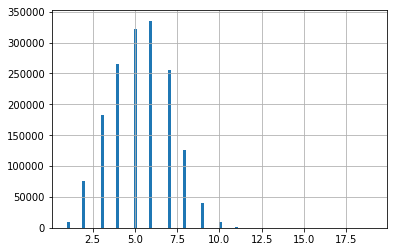

In [44]:
train['title'].apply(lambda x: len(x.split(' '))).hist(bins=100)

Se ve que con una longitud de 10 se soporta la mayoria de los ejemplos

In [45]:
maxlen = 10

In [46]:
def create_samples(titles, maxlen=25):
    samples = []
    unkown_token =[]
    unkown_title =[]
    
    for i,title in tqdm(enumerate(titles)):
        tokens = regexp_tokenize(title, pattern='(?u)\\b\\w\\w+\\b')
        x = []
        for token in tokens[:maxlen]:
            try:
                t_idx = vectorizer.vocabulary_[token]
                x.append(t_idx+1)
            except KeyError:
                unkown_token.append((token))
        if len(x) == 0:
            unkown_title.append(i)
        for _ in range(len(x),maxlen):
            x.append(0)
        samples.append(x)
    return np.asarray(samples), unkown_token,unkown_title

In [47]:
x_train, _, _ = create_samples(train['title'].values,maxlen = maxlen)
y_train = np.asarray(labels)
print(x_train.shape, y_train.shape)

1623476it [00:18, 86112.71it/s]


(1623476, 10) (1623476,)


In [48]:
test.head()

,title,label_quality,language,category
65069,clutch thunderbird,unreliable,spanish,AUTOMOTIVE_FRONT_BUMPERS
1004413,day fix extreme programa guias dvd digital,unreliable,spanish,RESISTANCE_BANDS
491231,suavizante triple fragancia limpieza,unreliable,spanish,FABRIC_SOFTENERS
316919,fusiogas codo ff saladillo termofusion gas,unreliable,spanish,CONNECTING_COUPLERS
841662,luz giro izquierda trasera zanella ceccato mt,unreliable,spanish,MOTORCYCLE_TURN_SIGNAL_LIGHTS


In [49]:
x_val, unknown_token, unknown_title = create_samples(test['title'].values,maxlen = maxlen)
y_val = np.asarray(le_.transform(test['category']))
print(x_val.shape, y_val.shape)
print('Cantidad de palabras desconocidas en test', len(unknown_token))
print('Cantidad de titulos de los que no se conocia ninguna palabra', len(unknown_title))

180387it [00:02, 82795.87it/s]


(180387, 10) (180387,)
Cantidad de palabras desconocidas en test 11309
Cantidad de titulos de los que no se conocia ninguna palabra 119


Veamos los titulos de los que no se conocieron palabras

In [50]:
test.iloc[unknown_title].head(20)

,title,label_quality,language,category
142440,tdtt,unreliable,spanish,BICYCLE_AND_MOTORCYCLE_ALARMS
554617,,unreliable,spanish,GAUZES
7820,parquerguitarra,unreliable,spanish,ACOUSTIC_GUITARS
1049376,,unreliable,spanish,SECURITY_SEALS
142929,,unreliable,spanish,BICYCLE_AND_MOTORCYCLE_ALARMS
5889286,dermacool,reliable,spanish,FOUNDATIONS
271452,,unreliable,spanish,CHIP_AND_DIP_SERVERS
81849,gazeboz,reliable,spanish,GAZEBOS
14809058,dïsa,reliable,spanish,NECKLACES
18893039,caniya larrouse,reliable,spanish,BATHROOM_FAUCETS


Se notan varios con errores de tipeos, otros que quedaron vacios luego del prosesamiento, seguramente por tener un solo caracter o se solamente stopwords o simbolos raros. Dado que la cantidad es demasiado baja no se van a tomar acciones para corregirlos

### Entrenando el modelo de clasificacion
Se van a intentar dos modelos tipos de modelos diferentes para clasificar los titulos. El primero de ellos basados en redes convolucionales y el segundo utilizando redes recurrentes LSTM.

Dado que las etiquetas tienen diferente cantidad de ejemplos se van a usar pesos para balancear los ejemplos durante el entrenamiento

In [51]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = dict(zip(np.unique(y_train), compute_class_weight('balanced', np.unique(y_train), y_train)))

#### Modelo CNN
A continuacion definimos un modelo utilizando bloques de Convoluciones de 1 dimension y Max Pooling. Segudo de dos capas completamente conectadas (Dense) y usando Dropout entre ellas.

In [52]:
from keras.models import Model
import keras.layers as L

filter_nr = 128
filter_size = 3
max_pool_size = 2
max_pool_strides = 2
# dense_nr = 512
denses = [512,512]
spatial_dropout = 0.0
dense_dropout = 0.2


title = L.Input(shape=(maxlen,))
emb_comment = L.Embedding(norm_matrix.shape[0], norm_matrix.shape[1],  trainable=False, name='emb_words')(title)
# emb_comment = L.SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(emb_comment)
block1 = L.BatchNormalization()(block1)
block1 = L.Activation('relu')(block1)
block1 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block1)
block1 = L.BatchNormalization()(block1)
block1 = L.PReLU()(block1)

activation_inner= 'relu'
#we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
#if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
resize_emb = L.Conv1D(filter_nr, kernel_size=1, padding='same', activation=activation_inner)(emb_comment)
resize_emb = L.Activation('relu')(resize_emb)
    
block1_output = L.add([block1, resize_emb])
block1_output = L.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation=activation_inner)(block1_output)
block2 = L.BatchNormalization()(block2)
block2 = L.Activation('relu')(block2)
block2 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation=activation_inner)(block2)
block2 = L.BatchNormalization()(block2)
block2 = L.Activation('relu')(block2)
block2_output = L.add([block2, block1_output])
block2_output = L.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

block3 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation=activation_inner)(block2_output)
block3 = L.BatchNormalization()(block3)
block3 = L.Activation('relu')(block3)
block3 = L.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation=activation_inner)(block3)
block3 = L.BatchNormalization()(block3)
block3 = L.Activation('relu')(block3)
    
block3_output = L.add([block3, block2_output])
block3_output = L.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

output = L.Flatten()(block3_output)
for dense_nr in denses:
    output = L.Dense(dense_nr, activation=activation_inner)(output)
    output = L.BatchNormalization()(output)
    output = L.Activation('relu')(output)
    output = L.Dropout(dense_dropout)(output)
output = L.Dense(len(le_.classes_), activation='softmax')(output)

model = Model(title, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

Using TensorFlow backend.
W1216 18:56:59.561217  6956 deprecation_wrapper.py:119] From c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1216 18:56:59.967750  6956 deprecation_wrapper.py:119] From c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1216 18:57:00.161729  6956 deprecation_wrapper.py:119] From c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1216 18:57:00.619850  6956 deprecation_wrapper.py:119] From c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\keras\backend\tensorflow_backend

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
emb_words (Embedding)           (None, 10, 1574)     326927670   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 128)      604544      emb_words[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 128)      512         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

Non-trainable params: 326,931,254
__________________________________________________________________________________________________


In [54]:
batch_size = 196

Entrenamos el modelo 

In [55]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, min_lr=1e-10, patience=3, monitor='val_loss', verbose=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, es],
                    class_weight=class_weights,
                    verbose=2,
                    batch_size=batch_size,
                    epochs=40
                   )

W1216 18:57:02.673423  6956 deprecation.py:323] From c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1623476 samples, validate on 180387 samples
Epoch 1/40
 - 342s - loss: 2.8079 - acc: 0.5477 - val_loss: 1.5181 - val_acc: 0.7182
Epoch 2/40
 - 295s - loss: 1.5182 - acc: 0.7234 - val_loss: 1.2758 - val_acc: 0.7583
Epoch 3/40
 - 289s - loss: 1.2621 - acc: 0.7614 - val_loss: 1.1430 - val_acc: 0.7800
Epoch 4/40
 - 290s - loss: 1.1089 - acc: 0.7840 - val_loss: 1.0731 - val_acc: 0.7916
Epoch 5/40
 - 288s - loss: 1.0093 - acc: 0.7977 - val_loss: 1.0058 - val_acc: 0.8016
Epoch 6/40
 - 287s - loss: 0.9284 - acc: 0.8085 - val_loss: 0.9889 - val_acc: 0.8061
Epoch 7/40
 - 287s - loss: 0.8705 - acc: 0.8169 - val_loss: 0.9558 - val_acc: 0.8124
Epoch 8/40
 - 287s - loss: 0.8237 - acc: 0.8235 - val_loss: 0.9445 - val_acc: 0.8153
Epoch 9/40
 - 290s - loss: 0.7851 - acc: 0.8289 - val_loss: 0.9417 - val_acc: 0.8152
Epoch 10/40
 - 294s - loss: 0.7503 - acc: 0.8344 - val_loss: 0.9382 - val_acc: 0.8174
Epoch 11/40
 - 298s - loss: 0.7217 - acc: 0.8385 - val_loss: 0.9296 - val_acc: 0.8178
Epoch 12/4

El entrenamiento nos da una accuracy de 81-82% (en diferentes ejecuciones) en el test que definimos. Veamos como le va con el Balanced Accuracy, una metrica que es util en casos de datasets desbalanceados. Se obtiene calculando el recall de cada clase y luego promediandolos todos. Esta fue la metrica que se definió en la competencia para definir los ganadores

In [56]:
from sklearn.metrics import balanced_accuracy_score

In [57]:
preds = model.predict(x_val)
val_pred = preds.argmax(axis=-1)
print(balanced_accuracy_score(y_val, val_pred))

c:\users\aferraresso\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.8211227980890373


Nos dio un score de 82.1 para el conjunto de Test que definimos

Veamos ahora si el modelo predijo al menos un ejemplo para cada categoria que hubiera en test (que son todas al haber hecho el split usando "stratified"

In [58]:
len(np.unique(y_val)), len(np.unique(val_pred))

(1572, 1573)

#### Modelo recurrente
A continuacion hacemos la prueba con un modelo de redes recurrentes. Esta compuesto por una capa LSTM seguido de dos capas densas como las usadas en CNN.

In [59]:
from keras.models import Model
import keras.layers as L

lstm_hiddens = 128
denses = [512,512]
spatial_dropout = 0.0
dense_dropout = 0.2


title = L.Input(shape=(maxlen,))
emb_comment = L.Embedding(norm_matrix.shape[0], norm_matrix.shape[1],  trainable=False, name='emb_words')(title)

output = L.LSTM(lstm_hiddens, return_sequences=False) (emb_comment)

for dense_nr in denses:
    output = L.Dense(dense_nr, activation=activation_inner)(output)
    output = L.BatchNormalization()(output)
    output = L.Activation('relu')(output)
    output = L.Dropout(dense_dropout)(output)
output = L.Dense(len(le_.classes_), activation='softmax')(output)

model_lstm = Model(title, output)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [60]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
emb_words (Embedding)        (None, 10, 1574)          326927670 
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               871936    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

Ponemos a entrenar el modelo

In [61]:
batch_size=196

In [62]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, min_lr=1e-10, patience=3, monitor='val_loss', verbose=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
history = model_lstm.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, es],
                    class_weight=class_weights,
                    verbose=2,
                    batch_size=batch_size,
                    epochs=40
                   )

Train on 1623476 samples, validate on 180387 samples
Epoch 1/40
 - 439s - loss: 2.7073 - acc: 0.5612 - val_loss: 1.7800 - val_acc: 0.6782
Epoch 2/40
 - 439s - loss: 1.5558 - acc: 0.7204 - val_loss: 1.4581 - val_acc: 0.7288
Epoch 3/40
 - 437s - loss: 1.2966 - acc: 0.7586 - val_loss: 1.1313 - val_acc: 0.7828
Epoch 4/40
 - 450s - loss: 1.1552 - acc: 0.7791 - val_loss: 1.0579 - val_acc: 0.7939
Epoch 5/40
 - 455s - loss: 1.0637 - acc: 0.7921 - val_loss: 1.0017 - val_acc: 0.8054
Epoch 6/40
 - 450s - loss: 0.9969 - acc: 0.8019 - val_loss: 0.9536 - val_acc: 0.8123
Epoch 7/40
 - 460s - loss: 0.9432 - acc: 0.8100 - val_loss: 0.9191 - val_acc: 0.8192
Epoch 8/40
 - 458s - loss: 0.9003 - acc: 0.8158 - val_loss: 0.9156 - val_acc: 0.8186
Epoch 9/40
 - 456s - loss: 0.8653 - acc: 0.8211 - val_loss: 0.8917 - val_acc: 0.8240
Epoch 10/40
 - 455s - loss: 0.8343 - acc: 0.8256 - val_loss: 0.8809 - val_acc: 0.8257
Epoch 11/40
 - 455s - loss: 0.8042 - acc: 0.8299 - val_loss: 0.8830 - val_acc: 0.8254
Epoch 12/4

El modelo recurrente nos esta dando mejores resultados, ya sea mirando el resultado de la funcion de loss (que tiene una gran mejora) como en el accuracy general, que sube rondado el 1% respecto del modelo con CNN. Veamos si esa mejora se da tambien utilizando balanced accuracy

In [63]:
preds_lstm = model_lstm.predict(x_val)
val_pred_lstm = preds_lstm.argmax(axis=-1)
print(balanced_accuracy_score(y_val, val_pred_lstm))

0.831938371216354


Claramente se mantiene la mejora en los resultados obtenidos por el modelo recurrente, sobre el modelo con capas convolucionales.

In [64]:
len(np.unique(y_val)), len(np.unique(val_pred))

(1572, 1573)

Al igual que el modelo con CNN, el modelo recurrente produjo al menos un resultado de cada clase.

#### Que pasa si mezclamos los resultados de los modelos
Como se ve, los modelos tienen diferentes resultados, y al provenir de diferentes formas muy diferentes sobre como procesar los datos, es posible que sus errores sean, en algunos casos, complementarios. Es decir, que se equivoquen de diferentes formas, lo que podría resultar en que si se promedian sus probabilidades el resultado sea mejor. Veamos si eso sucede

In [65]:
preds_avg = preds_lstm + preds
val_pred_avg = preds_avg.argmax(axis=-1)
print(balanced_accuracy_score(y_val, val_pred_avg))

0.8423788771993654


El hecho de promediar ambos modelos hizo que haya una mejora en los resultados, como suponiamos. Se consigue una mejora de 1% sobre el modelo con LSTM.

### Conclusiones
En estre trabajo se plantean dos posibles modelos de redes neuronales para la claisificacion de texto. En ambos casos se utilizo CSA para generar los embeddings que representan a las palabras, y luego se optó por representar los documentos como colecciones de esos embeddings. Ambos modelos tuvieron buenas performances siendo el de LSTM el que dió mejores resultados. También se pudo ver que con solo promediar las probabilidades que se obtiene de cada modelo se consigue una mejora en los resultados. Cabe destacar que el preprocesamiento de datos no incluye stemming ni lemmatizacion, solamente se realizó una limpieza de algunos caracteres y stopwords, lo que muestra el poder que tiene el uso CSA para la clasificación de textos.

### Posibles mejoras
- En esta entrega no se utilizó ninguna forma de lemmatization o de stemming. Inicialmente no se utilizó porque varios nombres de productos resultan de palabras que no existen en el idioma o son derivados de palabras del idioma inglés, por lo que primero habría que analizar como resuelven ésto los diferentes algoritmos. Queda pendiente para probar mas adelante.
- Utilizar la representacion que propone CSA para documentos y utilizar otro tipo de modelos para clasificar (como podrían ser SVM o RandomForest, o bien seguir con redes neuronales, pero usando solo capas densas)
- Trabajar con ngramas de diferentes tamaños, dado que suele pasar que sean nombres compuestos. En éste trabajo se trabajó unicamente con una palabra, mas que nada por limites de la memoria RAM para el vocabulario y el calculo de CSA. Se podría haber limitado el tamaño del vocabulario, pero al haber algunas categorías con muy pocos ejemplos me preocupaba que esas categorias no tuvieran palabras que llegaran a entrar en el vocabulario lo que haria imposible clasificarlas. Queda para mas adelante hacer un analisis de esos casos y determinar un tamaño ideal para ngramas y vocabulario, o bien buscar formas de calcular CSA que requieran menos memoria.
- Hacer un analisis mas exhaustivo de las stopwords que se definen para éste caso en particular.
- Probar otras formas de balanceo de clases que permitan trabajar con una parte mas grande del dataset.

### Comentario final
En su momento probé de enviar en la compentencia un modelo similar al creado en éste trabajo con CNN. El modelo en sí era casi igual, pero tenia un peor preprocesamiento (sobre todo al momento de obtener ejemplos para balancear las clases de train y en la obtencion de stopwords). Dicho obtuvo la posición 35 (sobre mas de 200 participantes), con un resultado de 0.88 conta el 0.91 que obtuvo el ganador. Probablemente con las mejoras hechas en éste trabajo o las planteadas en el punto anterior el resultado hubiera estado más cerca del ganador.